# Perform Classification on the ADNI dataset using SVMs, after MCA and OPNMF

## Importing Stuff:

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import warnings
import sys
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')
import pickle
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

## Read the data:

The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl".

The transformed through FAMD data is located at "./DATA/FAMD_Transformed_data_10_components.pkl"

In [50]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
lr_data.drop(labels=["MRID","Date","Age","APOE4_Alleles","APOE_Genotype","DLICV_baseline"], axis=1, inplace=True)
print(lr_data.shape)
lr_data.head()

(1302, 203)


,PTID,Sex,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,0,CN,-401.428503,-475.082401,-38.009137,-25.646775,75.669198,126.590353,124.482040,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,1,CN,596.355045,-177.499304,34.866428,-42.623326,36.073837,53.399103,-914.581355,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,0,CN,224.874560,1110.220538,134.798531,135.858384,109.271915,29.323465,1704.716715,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,0,Dementia,2633.277779,703.512999,-165.584181,-128.673356,-351.196493,-369.996116,-3669.094187,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,1,MCI,256.289641,599.953746,10.855725,32.230306,-150.404626,-107.055211,472.978958,...,0,0,0,1,1,0,0,0,1,2


In [51]:
mca_data = np.load("./DATA/MCA_Transformed_Genetic_data_10_components.pkl.npy")
print(mca_data.shape)
print(mca_data)

(1302, 10)
[[ 0.02371735  0.00758166  0.03124097 ...  0.02007631 -0.03371415
   0.02345717]
 [ 0.01051906 -0.02912091 -0.02414146 ... -0.03836163  0.01941386
   0.05144005]
 [ 0.00313658  0.02024018  0.03054364 ... -0.01525235 -0.01290234
   0.03417399]
 ...
 [-0.00580048  0.00667212  0.03939653 ...  0.01200354  0.00510257
  -0.04572104]
 [ 0.06722299 -0.00955109 -0.08351047 ...  0.02180382  0.01885345
  -0.038522  ]
 [ 0.03114945  0.02050712  0.03119218 ...  0.01215095 -0.03140962
   0.02663309]]


In [52]:
opnmf_coeffs = pd.read_csv("./DATA/loading_coefficients_30components.tsv", sep='\t')
print("opnmf_coeffs shape: ", opnmf_coeffs.shape)

o = list(opnmf_coeffs.columns)
opnmf_names = ["imaging_"+o[i] for i in range(o.index("component_1"), len(o))]

opnmf_coeffs shape:  (1294, 33)


### Create the Dataset:

In [53]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = genetic_columns
print("Before: ",lr_data.shape)
mca = lr_data.drop(labels = columns_to_drop, axis=1)

# Embed them into the new dataset:
component_labels = ["genetic_component_"+str(x+1) for x in range(mca_data.shape[1])] 
mca[component_labels] = mca_data
print("After: ",mca.shape)
mca.head()

Before:  (1302, 203)
After:  (1302, 159)


,PTID,Sex,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,...,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,genetic_component_7,genetic_component_8,genetic_component_9,genetic_component_10
0,002_S_0295,0,CN,-401.428503,-475.082401,-38.009137,-25.646775,75.669198,126.590353,124.482040,...,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,0.013514,0.020076,-0.033714,0.023457
9,002_S_0413,1,CN,596.355045,-177.499304,34.866428,-42.623326,36.073837,53.399103,-914.581355,...,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,-0.009398,-0.038362,0.019414,0.051440
24,002_S_0559,0,CN,224.874560,1110.220538,134.798531,135.858384,109.271915,29.323465,1704.716715,...,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,-0.020733,-0.015252,-0.012902,0.034174
31,002_S_0619,0,Dementia,2633.277779,703.512999,-165.584181,-128.673356,-351.196493,-369.996116,-3669.094187,...,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,0.015067,-0.026107,0.044011,0.042946
45,002_S_0729,1,MCI,256.289641,599.953746,10.855725,32.230306,-150.404626,-107.055211,472.978958,...,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,-0.030461,-0.027636,-0.024174,0.028044


In [54]:
mca = mca[mca['PTID'].isin(opnmf_coeffs['participant_id'])]
mca.reset_index(drop=True, inplace=True)
print(mca.shape)
mca

(1294, 159)


,PTID,Sex,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,...,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,genetic_component_7,genetic_component_8,genetic_component_9,genetic_component_10
0,002_S_0295,0,CN,-401.428503,-475.082401,-38.009137,-25.646775,75.669198,126.590353,124.482040,...,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,0.013514,0.020076,-0.033714,0.023457
1,002_S_0413,1,CN,596.355045,-177.499304,34.866428,-42.623326,36.073837,53.399103,-914.581355,...,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,-0.009398,-0.038362,0.019414,0.051440
2,002_S_0559,0,CN,224.874560,1110.220538,134.798531,135.858384,109.271915,29.323465,1704.716715,...,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,-0.020733,-0.015252,-0.012902,0.034174
3,002_S_0619,0,Dementia,2633.277779,703.512999,-165.584181,-128.673356,-351.196493,-369.996116,-3669.094187,...,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,0.015067,-0.026107,0.044011,0.042946
4,002_S_0729,1,MCI,256.289641,599.953746,10.855725,32.230306,-150.404626,-107.055211,472.978958,...,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,-0.030461,-0.027636,-0.024174,0.028044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,941_S_4377,1,MCI,-93.022177,-424.608614,-50.134091,-9.424328,-64.640506,-118.006565,-1097.240060,...,0.023015,-0.080319,0.013511,-0.020350,-0.000152,-0.030639,0.032792,-0.009734,0.001214,-0.033358
1290,941_S_4420,0,MCI,-1112.835242,-753.951132,68.869183,43.758119,55.391240,-95.252892,-1236.870850,...,-0.028817,-0.011526,0.053327,0.038954,-0.041069,0.012728,0.144778,0.037506,0.022431,-0.059722
1291,941_S_4764,1,MCI,962.807784,952.741047,-140.514933,-117.232597,-82.642887,-119.797822,303.378300,...,-0.005800,0.006672,0.039397,-0.082080,-0.005208,-0.015238,0.010931,0.012004,0.005103,-0.045721
1292,941_S_5124,1,CN,-41.208373,-537.067127,-119.769978,-140.847895,-129.660156,-3.839927,-2073.106002,...,0.067223,-0.009551,-0.083510,0.025694,0.039165,0.025772,-0.004258,0.021804,0.018853,-0.038522


In [55]:
opnmf = mca.drop(labels = MRI_columns, axis = 1)
opnmf[opnmf_names] = opnmf_coeffs.loc[:,"component_1":"component_30"]

data = opnmf.reset_index(drop=True)
print(data.shape)
data

(1294, 44)


,PTID,Sex,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
0,002_S_0295,0,CN,0,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,...,839.09924,619.73230,681.45100,832.04670,659.40180,598.43787,737.67930,849.03940,653.38510,529.58984
1,002_S_0413,1,CN,0,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,...,765.77704,861.15450,674.06160,755.78380,719.56067,937.99410,694.54680,825.40790,766.40090,773.84576
2,002_S_0559,0,CN,0,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,...,1046.81020,843.50710,877.13410,885.02180,911.55505,906.45730,701.53510,894.42840,837.21240,713.27203
3,002_S_0619,0,Dementia,1,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,...,857.98660,813.39230,913.79160,875.58560,1001.27344,827.59820,686.68600,651.28410,764.98206,742.52910
4,002_S_0729,1,MCI,2,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,...,600.88570,702.83550,673.74255,764.65850,650.25160,685.98645,587.51636,666.16100,624.62510,647.47455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,941_S_4377,1,MCI,2,0.023015,-0.080319,0.013511,-0.020350,-0.000152,-0.030639,...,672.95850,616.05360,666.50740,705.68400,637.70960,647.19086,688.68317,718.95026,823.27057,576.15560
1290,941_S_4420,0,MCI,2,-0.028817,-0.011526,0.053327,0.038954,-0.041069,0.012728,...,892.92975,755.48553,821.90106,843.07960,776.35120,736.08510,880.40970,853.80896,764.91910,721.72675
1291,941_S_4764,1,MCI,2,-0.005800,0.006672,0.039397,-0.082080,-0.005208,-0.015238,...,658.54535,687.58010,723.93310,585.88025,756.96893,636.93823,558.68760,740.46063,672.26760,603.86285
1292,941_S_5124,1,CN,0,0.067223,-0.009551,-0.083510,0.025694,0.039165,0.025772,...,847.88275,748.22550,611.70123,806.31000,747.58220,767.06160,608.41400,715.23220,710.96140,619.92320


In [56]:
# Check for inf or NaN:
data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

,PTID,Sex,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
0,002_S_0295,0,CN,0,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,...,839.09924,619.73230,681.45100,832.04670,659.40180,598.43787,737.67930,849.03940,653.38510,529.58984
1,002_S_0413,1,CN,0,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,...,765.77704,861.15450,674.06160,755.78380,719.56067,937.99410,694.54680,825.40790,766.40090,773.84576
2,002_S_0559,0,CN,0,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,...,1046.81020,843.50710,877.13410,885.02180,911.55505,906.45730,701.53510,894.42840,837.21240,713.27203
3,002_S_0619,0,Dementia,1,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,...,857.98660,813.39230,913.79160,875.58560,1001.27344,827.59820,686.68600,651.28410,764.98206,742.52910
4,002_S_0729,1,MCI,2,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,...,600.88570,702.83550,673.74255,764.65850,650.25160,685.98645,587.51636,666.16100,624.62510,647.47455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,941_S_4377,1,MCI,2,0.023015,-0.080319,0.013511,-0.020350,-0.000152,-0.030639,...,672.95850,616.05360,666.50740,705.68400,637.70960,647.19086,688.68317,718.95026,823.27057,576.15560
1290,941_S_4420,0,MCI,2,-0.028817,-0.011526,0.053327,0.038954,-0.041069,0.012728,...,892.92975,755.48553,821.90106,843.07960,776.35120,736.08510,880.40970,853.80896,764.91910,721.72675
1291,941_S_4764,1,MCI,2,-0.005800,0.006672,0.039397,-0.082080,-0.005208,-0.015238,...,658.54535,687.58010,723.93310,585.88025,756.96893,636.93823,558.68760,740.46063,672.26760,603.86285
1292,941_S_5124,1,CN,0,0.067223,-0.009551,-0.083510,0.025694,0.039165,0.025772,...,847.88275,748.22550,611.70123,806.31000,747.58220,767.06160,608.41400,715.23220,710.96140,619.92320


## Perform Classification using SVMs:

In [57]:
def perform_svm(X,Y,kern= None, model=svm.LinearSVC(), params=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)
    
    
    clf = GridSearchCV(model, params, n_jobs=-1, cv=10)
    clf.fit(X_train,Y_train)
    print("Best Parameters for untrained data (",kern," kernel):",clf.best_params_)
    pred =  clf.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred, normalize='true')
    bal_acc = balanced_accuracy_score(Y_test, pred)
    if kern == None:
        print('Accuracy (Linear Kernel): ', "%.2f" % (acc*100))
        print('Balanced Accuracy (Linear Kernel): ', "%.2f" % (bal_acc*100))
        print('F1 (Linear Kernel): ', "%.2f" % (f1*100))
    else:
        print('Accuracy ('+kern+' Kernel): ', "%.2f" % (acc*100))
        print('Balanced Accuracy ('+kern+' Kernel): ', "%.2f" % (bal_acc*100))
        print('F1 ('+kern+' Kernel): ', "%.2f" % (f1*100))       
    return acc, f1, np.around(cm, decimals=2), bal_acc

In [58]:
Accuracies = []
F1s = []
Balanced_Accuracies = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

l, p, r = svm.LinearSVC(dual=False,max_iter=2000), svm.SVC(), svm.SVC()
l_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
p_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'degree':[2,3,4,5],
            'coef0':[0.0,10.0,100.0,1000.0],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
r_params = {'C': [0.00001, 0.001, 0.01, 0.1, 1, 10], 
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

    
# Get the values that interest us:
X = data[opnmf_names + component_labels]
Y = data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):

lin_accuracy, lin_f1, lin_cm, lin_bal_acc= perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm, poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm, rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc


names = ['Linear', 'Poly', 'RBF']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

Best Parameters for untrained data ( linear  kernel): {'C': 0.1}
Accuracy (linear Kernel):  52.12
Balanced Accuracy (linear Kernel):  49.03
F1 (linear Kernel):  51.94
Best Parameters for untrained data ( poly  kernel): {'C': 1e-05, 'coef0': 0.0, 'degree': 2, 'gamma': 0.0001}
Accuracy (poly Kernel):  51.35
Balanced Accuracy (poly Kernel):  33.33
F1 (poly Kernel):  34.85
Best Parameters for untrained data ( rbf  kernel): {'C': 1e-05, 'gamma': 0.0001}
Accuracy (rbf Kernel):  51.35
Balanced Accuracy (rbf Kernel):  33.33
F1 (rbf Kernel):  34.85
Model with max Accuracy:  Linear  with an Accuracy score of  52.124
Model with max F1 Score:  Linear  with an F1 Score of  51.938
Model with max Balanced Accuracy Score:  Linear  with a Balanced Accuracy Score of  49.032


### Visualise the results:

In [59]:
def barplot_scores(Accuracies, F1s, Names, Bal_Accuracies = None):
    barWidth = 0.2
    fig = plt.subplots(figsize =(14, 8))
    br1 = np.arange(len(Accuracies))
    br2 = [x + barWidth for x in br1] 
    if Bal_Accuracies:
        br3 = [x + barWidth for x in br2] 
    plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
    plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth, edgecolor ='grey', label ='F1 score')
    if Bal_Accuracies:
        plt.bar(br3, [100*x for x in Bal_Accuracies], color ='g', width = barWidth, edgecolor ='grey', label ='Balanced Accuracy')
    plt.xlabel('SVM', fontweight ='bold', fontsize = 15)
    plt.ylabel('Accuracy Score (%)', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(Accuracies))],Names)
    plt.grid()
    plt.legend()
    plt.show()
    return

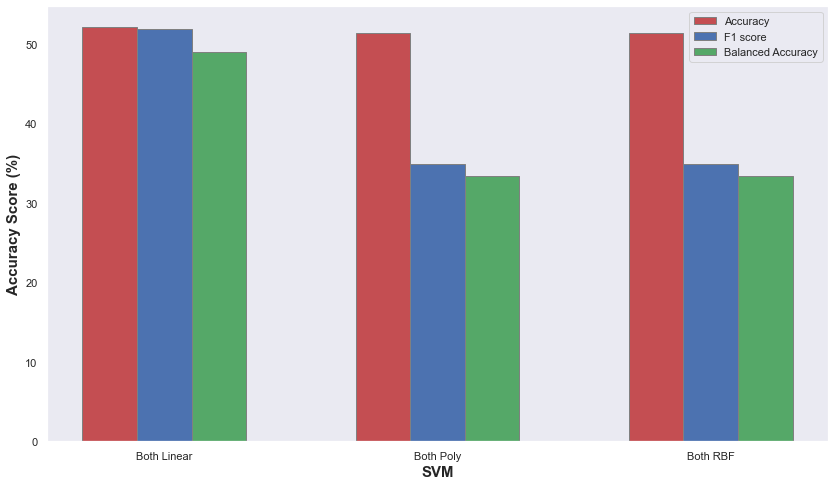

In [60]:
barplot_scores(Accuracies, F1s, ['Both Linear', 'Both Poly', 'Both RBF'], Balanced_Accuracies)

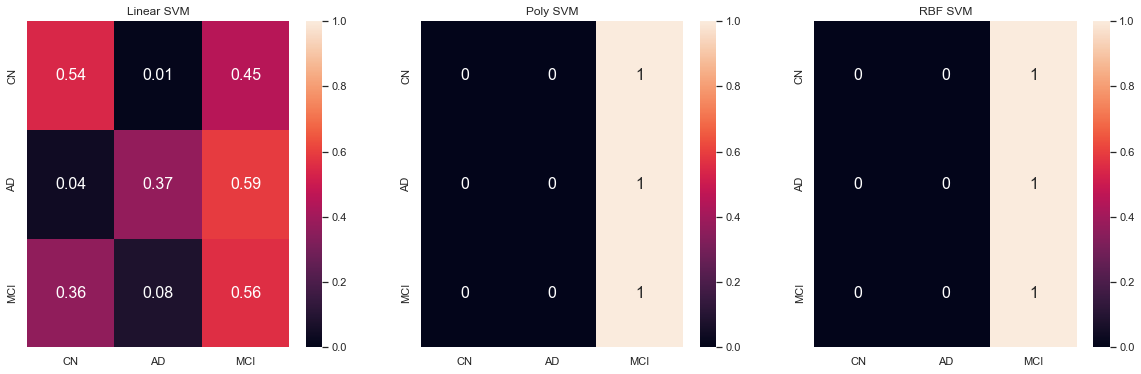

In [61]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,6));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Linear SVM")
sns.heatmap(poly_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Poly SVM")
sns.heatmap(rbf_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("RBF SVM")
plt.show()

## Try with balancing and scaling:

In [62]:
# Scaling the data I think perhaps is not needed since they are relatively low and close values:
display(data.describe())
# # Scale the data:
scaler = preprocessing.StandardScaler()
scaler.fit(data[opnmf_names])
data_scaled = scaler.transform(data[opnmf_names])
data[opnmf_names] = data_scaled
display(data.describe())

,Sex,Diagnosis_nearest_2.0_cat,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,genetic_component_7,genetic_component_8,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
count,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,...,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000
mean,0.431221,1.147604,-0.000071,0.000012,-0.000035,-0.000067,-0.000153,-0.000045,-0.000062,-0.000027,...,832.377176,785.466661,743.112438,751.624929,739.858197,744.528792,719.829262,774.191859,751.537933,686.830767
std,0.495438,0.890270,0.044553,0.041793,0.040939,0.039213,0.038621,0.036577,0.035537,0.034014,...,137.544145,119.337638,109.436300,119.358767,118.147490,120.946548,108.284309,120.942445,111.793852,99.958751
min,0.000000,0.000000,-0.138601,-0.124837,-0.147842,-0.181075,-0.133410,-0.163209,-0.141577,-0.100081,...,460.988160,353.536130,464.752350,413.940160,364.682860,453.444370,353.239440,400.764280,420.010400,388.626100
25%,0.000000,0.000000,-0.028224,-0.023181,-0.024943,-0.024695,-0.027439,-0.019638,-0.018586,-0.023814,...,735.486650,705.654567,669.527582,671.791912,657.370375,656.151563,646.184825,696.866845,672.129320,619.188275
50%,0.000000,1.000000,0.002426,-0.001662,-0.000834,0.002315,0.000709,0.000699,0.000627,-0.003757,...,829.508780,780.940705,734.538470,749.446330,731.065555,737.287950,712.069420,779.084045,741.242580,677.992400
75%,1.000000,2.000000,0.027272,0.020277,0.023488,0.027909,0.027763,0.023007,0.018358,0.020530,...,919.835075,857.195625,808.003338,825.998950,811.361300,823.273120,788.066862,856.068262,821.149250,744.988095
max,1.000000,2.000000,0.214711,0.245917,0.184574,0.118036,0.111114,0.102047,0.144778,0.160082,...,1380.400300,1266.960700,1147.821000,1351.282800,1272.634200,1244.540300,1150.189600,1161.774700,1223.262200,1024.356800


,Sex,Diagnosis_nearest_2.0_cat,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,genetic_component_7,genetic_component_8,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
count,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,...,1.294000e+03,1.294000e+03,1.294000e+03,1.294000e+03,1.294000e+03,1.294000e+03,1.294000e+03,1.294000e+03,1.294000e+03,1.294000e+03
mean,0.431221,1.147604,-0.000071,0.000012,-0.000035,-0.000067,-0.000153,-0.000045,-0.000062,-0.000027,...,7.061156e-17,-3.694452e-16,4.902484e-16,1.862669e-16,1.179719e-16,-4.641659e-16,-3.176233e-16,4.153041e-16,4.152612e-17,1.532348e-16
std,0.495438,0.890270,0.044553,0.041793,0.040939,0.039213,0.038621,0.036577,0.035537,0.034014,...,1.000387e+00,1.000387e+00,1.000387e+00,1.000387e+00,1.000387e+00,1.000387e+00,1.000387e+00,1.000387e+00,1.000387e+00,1.000387e+00
min,0.000000,0.000000,-0.138601,-0.124837,-0.147842,-0.181075,-0.133410,-0.163209,-0.141577,-0.100081,...,-2.701188e+00,-3.620798e+00,-2.544564e+00,-2.830251e+00,-3.176711e+00,-2.407650e+00,-3.386747e+00,-3.088841e+00,-2.966672e+00,-2.984431e+00
25%,0.000000,0.000000,-0.028224,-0.023181,-0.024943,-0.024695,-0.027439,-0.019638,-0.018586,-0.023814,...,-7.047046e-01,-6.690509e-01,-6.726589e-01,-6.691078e-01,-6.984466e-01,-7.309956e-01,-6.803655e-01,-6.396010e-01,-7.105875e-01,-6.769657e-01
50%,0.000000,1.000000,0.002426,-0.001662,-0.000834,0.002315,0.000709,0.000699,0.000627,-0.003757,...,-2.086243e-02,-3.794030e-02,-7.837695e-02,-1.825959e-02,-7.444967e-02,-5.989126e-02,-7.168944e-02,4.046617e-02,-9.212791e-02,-8.845433e-02
75%,1.000000,2.000000,0.027272,0.020277,0.023488,0.027909,0.027763,0.023007,0.018358,0.020530,...,6.360991e-01,6.012914e-01,5.931851e-01,6.233541e-01,6.054360e-01,6.513189e-01,6.304144e-01,6.772482e-01,6.229165e-01,5.820382e-01
max,1.000000,2.000000,0.214711,0.245917,0.184574,0.118036,0.111114,0.102047,0.144778,0.160082,...,3.985884e+00,4.036281e+00,3.699550e+00,5.025938e+00,4.511158e+00,4.135751e+00,3.975892e+00,3.205927e+00,4.221222e+00,3.377959e+00


In [63]:
# Balance the data through Undersampling - Use the same indexes as the LR Data:
print(data['Diagnosis_nearest_2.0'].value_counts())
data.head(10)

MCI         622
CN          431
Dementia    241
Name: Diagnosis_nearest_2.0, dtype: int64


,PTID,Sex,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
0,002_S_0295,0,CN,0,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,...,0.048891,-1.389322,-0.563664,0.674042,-0.681246,-1.208364,0.164908,0.619108,-0.878320,-1.573666
1,002_S_0413,1,CN,0,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,...,-0.484396,0.634478,-0.631212,0.034857,-0.171865,1.600212,-0.233572,0.423638,0.133001,0.870846
2,002_S_0559,0,CN,0,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,...,1.559615,0.486543,1.225128,1.118045,1.453804,1.339361,-0.169011,0.994548,0.766657,0.264624
3,002_S_0619,0,Dementia,1,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,...,0.186263,0.234096,1.560224,1.038957,2.213473,0.687093,-0.306195,-1.016643,0.120305,0.557429
4,002_S_0729,1,MCI,2,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,...,-1.683685,-0.692683,-0.634129,0.109239,-0.758723,-0.484222,-1.222375,-0.893587,-1.135679,-0.393877
5,002_S_0816,0,Dementia,1,0.038518,-0.028622,0.003513,0.046327,-0.024738,0.000350,...,0.792922,-0.299782,0.773713,0.877742,-0.518551,-0.127107,-0.863093,0.004066,0.952623,-0.698107
6,002_S_0938,1,Dementia,1,-0.037936,-0.005529,0.038916,0.010216,0.001769,0.033678,...,-1.551189,-0.364480,-0.471306,-1.720045,-0.318781,0.476993,-0.404486,-2.206596,0.741984,-0.260770
7,002_S_0954,1,MCI,2,0.015300,0.011375,-0.021789,-0.024325,0.031788,0.004418,...,-1.704096,-2.568731,-2.157949,-2.199971,-2.100238,-1.164348,-1.844668,-1.535393,-1.606446,-1.836119
8,002_S_0955,1,Dementia,1,-0.035374,-0.006874,-0.009995,0.034404,-0.036145,0.037841,...,0.080791,-1.083333,-0.337499,-1.191291,0.585347,-0.355103,-0.559200,-1.536355,-1.476627,-0.250134
9,002_S_1018,1,Dementia,1,0.033910,-0.036307,-0.001956,-0.014123,0.024256,-0.041852,...,0.216959,0.333075,-0.424781,0.225434,-0.553904,-1.373559,-0.149119,0.157157,-0.271495,-0.208035


In [64]:
def undersample(df, ylabel='Diagnosis_nearest_2.0'):
    classes = df[ylabel].value_counts().to_dict() # specific to this dataset
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[ylabel] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [65]:
data_usampled = undersample(data)
data = data_usampled.sort_values('PTID', ascending=True)
data.reset_index(drop=True, inplace=True)

print(data['Diagnosis_nearest_2.0'].value_counts())
print(data.shape)
data.head(10)

CN          241
Dementia    241
MCI         241
Name: Diagnosis_nearest_2.0, dtype: int64
(723, 44)


,PTID,Sex,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
0,002_S_0413,1,CN,0,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,...,-0.484396,0.634478,-0.631212,0.034857,-0.171865,1.600212,-0.233572,0.423638,0.133001,0.870846
1,002_S_0559,0,CN,0,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,...,1.559615,0.486543,1.225128,1.118045,1.453804,1.339361,-0.169011,0.994548,0.766657,0.264624
2,002_S_0619,0,Dementia,1,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,...,0.186263,0.234096,1.560224,1.038957,2.213473,0.687093,-0.306195,-1.016643,0.120305,0.557429
3,002_S_0816,0,Dementia,1,0.038518,-0.028622,0.003513,0.046327,-0.024738,0.000350,...,0.792922,-0.299782,0.773713,0.877742,-0.518551,-0.127107,-0.863093,0.004066,0.952623,-0.698107
4,002_S_0938,1,Dementia,1,-0.037936,-0.005529,0.038916,0.010216,0.001769,0.033678,...,-1.551189,-0.364480,-0.471306,-1.720045,-0.318781,0.476993,-0.404486,-2.206596,0.741984,-0.260770
5,002_S_0955,1,Dementia,1,-0.035374,-0.006874,-0.009995,0.034404,-0.036145,0.037841,...,0.080791,-1.083333,-0.337499,-1.191291,0.585347,-0.355103,-0.559200,-1.536355,-1.476627,-0.250134
6,002_S_1018,1,Dementia,1,0.033910,-0.036307,-0.001956,-0.014123,0.024256,-0.041852,...,0.216959,0.333075,-0.424781,0.225434,-0.553904,-1.373559,-0.149119,0.157157,-0.271495,-0.208035
7,002_S_4213,1,CN,0,0.004812,0.022499,0.004210,0.023597,0.036661,0.000039,...,-0.175323,-0.077224,-0.238004,-0.997494,0.638273,-0.164303,-0.043128,0.643625,0.353865,-1.009508
8,002_S_4225,0,CN,0,0.023554,-0.027011,-0.036138,-0.048739,0.067257,0.022633,...,1.424183,1.222534,3.699550,2.226527,0.419488,2.036152,0.211028,2.536461,2.528032,1.499566
9,002_S_4270,1,CN,0,0.009836,0.006694,0.010273,-0.027463,-0.008584,-0.004312,...,-0.586583,-0.510707,0.065088,0.514292,-0.817108,-0.145238,-0.482712,-0.145530,-0.760536,0.143072


In [66]:
Accuracies = []
F1s = []
Balanced_Accuracies = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

l, p, r = svm.LinearSVC(dual=False,max_iter=2000), svm.SVC(), svm.SVC()
l_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
p_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'degree':[2,3,4,5],
            'coef0':[0.0,10.0,100.0,1000.0],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
r_params = {'C': [0.00001, 0.001, 0.01, 0.1, 1, 10], 
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

    
# Get the values that interest us:
X = data[opnmf_names + component_labels]
Y = data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):

lin_accuracy, lin_f1, lin_cm, lin_bal_acc= perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm, poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm, rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc


names = ['Linear', 'Poly', 'RBF']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

Best Parameters for untrained data ( linear  kernel): {'C': 0.01}
Accuracy (linear Kernel):  56.55
Balanced Accuracy (linear Kernel):  58.18
F1 (linear Kernel):  53.78
Best Parameters for untrained data ( poly  kernel): {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 0.01}
Accuracy (poly Kernel):  54.48
Balanced Accuracy (poly Kernel):  55.72
F1 (poly Kernel):  53.25
Best Parameters for untrained data ( rbf  kernel): {'C': 10, 'gamma': 0.01}
Accuracy (rbf Kernel):  54.48
Balanced Accuracy (rbf Kernel):  55.72
F1 (rbf Kernel):  53.25
Model with max Accuracy:  Linear  with an Accuracy score of  56.552
Model with max F1 Score:  Linear  with an F1 Score of  53.777
Model with max Balanced Accuracy Score:  Linear  with a Balanced Accuracy Score of  58.184


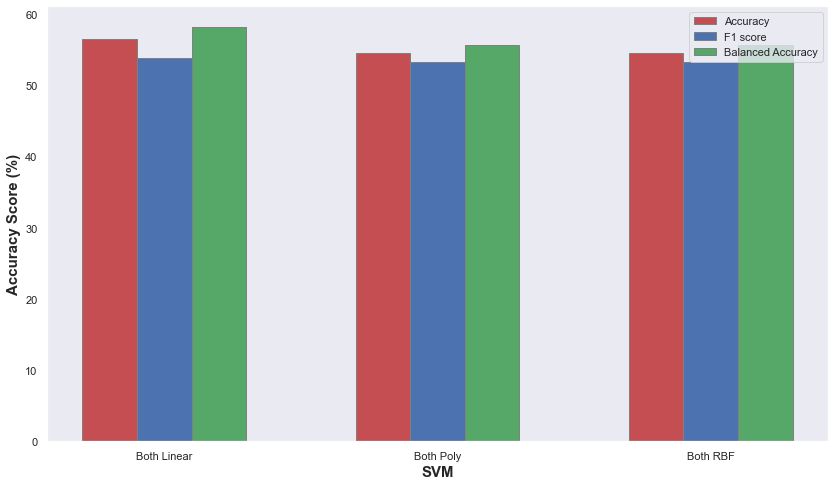

In [67]:
barplot_scores(Accuracies, F1s, ['Both Linear', 'Both Poly', 'Both RBF'], Balanced_Accuracies)

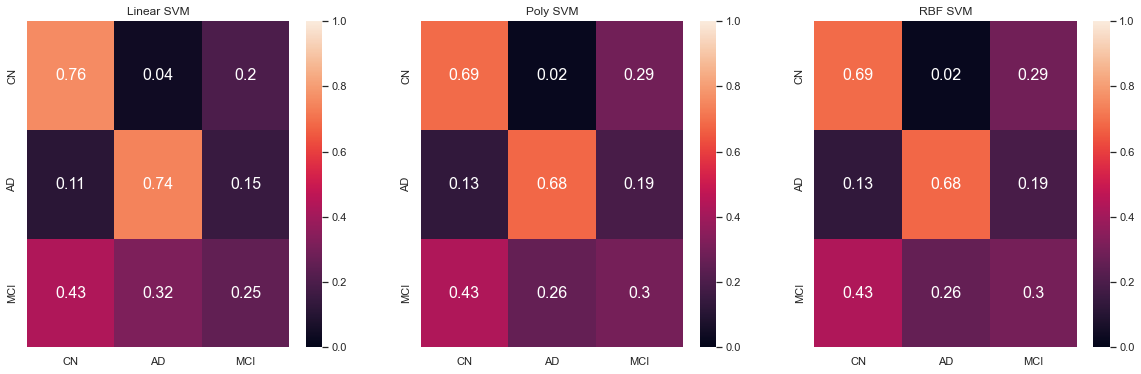

In [68]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,6));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Linear SVM")
sns.heatmap(poly_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Poly SVM")
sns.heatmap(rbf_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("RBF SVM")
plt.show()